# Comparing empirical vs. simulated power spectra for multiple subjects

## Setup

In [1]:
# Generic stuff
import os,sys,glob, numpy as np, pandas as pd
from scipy.io import loadmat
from itertools import product
from scipy.interpolate import interp1d

# Viz stuff
%matplotlib inline
from matplotlib import pyplot as plt


# CTWC model code
sys.path.append('../ctwc')
from ctwc_model import run_net_sim

/nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Define some variables

In [2]:
# 1-node weights & delays
weights_1N = np.array([[1.]])
delays_1N = np.array([[1.]])

## Load HCP data

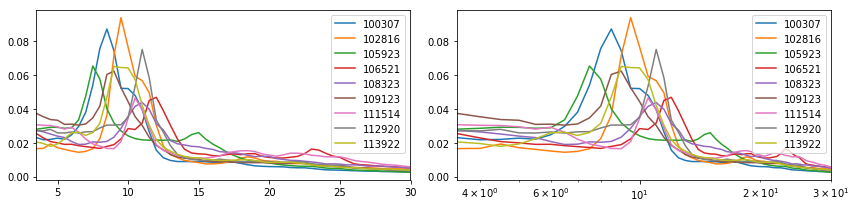

In [3]:
subs = np.loadtxt('../data/S95_MEG.txt').astype(int)
all_ps = {}
for sub in subs[:10]:
    f = '../data/%s_MEG_3-Restin_powavg.mat' %sub
    if os.path.isfile(f):
        mat = loadmat(f,struct_as_record=False,squeeze_me=True)['freq']
        hcp_ps = pd.DataFrame(mat.powspctrm,columns=mat.freq,index=mat.label).T
        hcp_ps = hcp_ps.loc[3:45]
        hcp_ps_norm = hcp_ps / hcp_ps.sum(axis=0)
        all_ps[sub] = hcp_ps_norm
df_all_ps = pd.concat(all_ps,sort=False)


fig, ax = plt.subplots(ncols=2,figsize=(12,3))
df_all_ps.mean(axis=1).unstack().T.loc[:30].plot(ax=ax[0])
df_all_ps.mean(axis=1).unstack().T.loc[:30].plot(ax=ax[1],logx=True)
plt.tight_layout()

In [4]:
# another plot with all 90 HCP subjects... ?

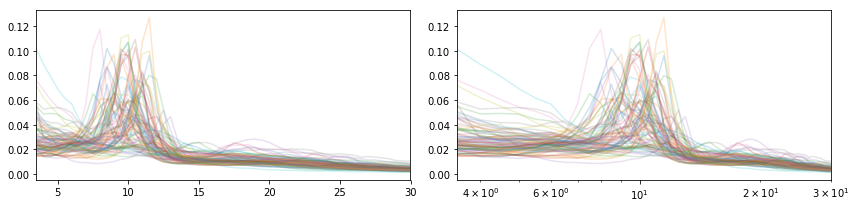

In [5]:
subs = np.loadtxt('../data/S95_MEG.txt').astype(int)
all_ps = {}
for sub in subs:
    f = '../data/%s_MEG_3-Restin_powavg.mat' %sub
    if os.path.isfile(f):
        mat = loadmat(f,struct_as_record=False,squeeze_me=True)['freq']
        hcp_ps = pd.DataFrame(mat.powspctrm,columns=mat.freq,index=mat.label).T
        hcp_ps = hcp_ps.loc[3:45]
        hcp_ps_norm = hcp_ps / hcp_ps.sum(axis=0)
        all_ps[sub] = hcp_ps_norm
df_all_ps = pd.concat(all_ps,sort=False)


fig, ax = plt.subplots(ncols=2,figsize=(12,3))
df_all_ps.mean(axis=1).unstack().T.loc[:30].plot(ax=ax[0],legend=False,alpha=0.2)
df_all_ps.mean(axis=1).unstack().T.loc[:30].plot(ax=ax[1],logx=True,legend=False,alpha=0.2)
plt.tight_layout()

## Compute modelled spectra

In [89]:
%%time

a_thrtns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4] # ,0.5,0.6,0.7,0.8,0.9,1.0]
combs = list(product(a_thrtns))
combsdicts = [{'a_th': i[0], 'a_rtn': i[0]} for i in combs]

all_sims = {}
all_corrs = {}
all_sims_norm = {}
all_corrs_norm = {}
max_corrs = {}
max_corrs_norm = {}
noise_level = 0.01
T=1024*1

meanps = df_all_ps.mean(axis=1).unstack().T
substodo = meanps.columns

all_fitcorrs = {}
all_fitdats = {}

for sub in substodo:
    
    meg_dat = meanps.loc[2:46][sub].values
    meg_freqs = meanps.loc[2:46].index.values

    for c_it,c in enumerate(combsdicts):
        ssX_params = dict(I_o=0., # None,
             wee = 1.4,wei = 1.4,wie = -3., wii = -0.5, # wie = -2.,wii = -0.5,
            wertn = 0.6,weth = .6,wthi = 0.2,wthe = 1.65,wrtnth = -2.,wthrtn = 2.,
            D_e=noise_level,D_i=noise_level,D_th=noise_level,D_rtn=noise_level,#D_e = .001,D_i= .001,D_th = 0.001,D_rtn = 0.001,
            T=T,#1024*1,#T,#T = 1024*4,# 20,
            P=1,Q = 1,Dt = 0.001,
            dt = 0.1,gain = 20.,threshold = 0.,Pi = 3.14159,
            g = 5., # 10., # 1., #-0.9,
            a_e = 0.9,
            a_i = 0.9, 
            a_th=0.25, 
            a_rtn=0.25, # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2,
            i_e = -0.35,i_i = -0.3,i_th = 0.5,i_rtn = -0.8,
            tau1  = 20.,tau2 = 5.,T_transient=1000,
            stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'],
            weights=weights_1N*0.,
            delays=delays_1N,
            K=1, #stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'], #weights=_df_w.values,delays=_df_d.values,K=83,
            return_ts=True,compute_connectivity=False,
            welch_nperseg=700)#True) #False)

        for k,v in c.items(): ssX_params[k] = v
    
        sim_res = run_net_sim(**ssX_params)
        sim_dat = sim_res[1]['e'].loc[4:45].mean(axis=1).values
        sim_freqs = sim_res[1]['e'].loc[4:45].index.values
        thing = interp1d(meg_freqs,meg_dat)
        meg_interp2sim = thing(sim_freqs)#df.index)
        all_sims[c_it] = pd.DataFrame([meg_interp2sim,sim_dat,sim_freqs],index=['meg_interp2sim', 
                                                                      'sim_dat', 'sim_freqs']).T
        all_sims[c_it].set_index('sim_freqs', inplace=True)
    
        sim_dat_norm = sim_dat/sim_dat.max()
        meg_interp2sim_norm = meg_interp2sim/meg_interp2sim.max()
    
        cc = np.corrcoef(sim_dat,meg_interp2sim)[0,1]
        all_corrs[c_it] = cc    
        df_all_corrs = pd.DataFrame(all_corrs.values(),index=all_corrs.keys())[0]
        max_corrs[c_it] = df_all_corrs.loc[df_all_corrs.idxmax()]
    
        cc_norm = np.corrcoef(sim_dat_norm,meg_interp2sim_norm)[0,1]
        all_corrs_norm[c_it] = cc_norm    
        df_all_corrs_norm = pd.DataFrame(all_corrs_norm.values(),index=all_corrs_norm.keys())[0]
        max_corrs_norm[c_it] = df_all_corrs_norm.loc[df_all_corrs_norm.idxmax()]    

    df_meg_interp2sim = pd.DataFrame(meg_interp2sim,index=sim_freqs)[0]
    df_meg_interp2sim_norm = df_meg_interp2sim = df_meg_interp2sim.max()

    df_all_sim_dats = pd.concat(all_sims)['sim_dat'].unstack().T
    df_all_sim_dats['meg_interp2sim'] = meg_interp2sim

    df_all_sim_dats_norm = df_all_sim_dats / df_all_sim_dats.max()
    df_all_sim_dats_norm['meg_interp2sim'] = meg_interp2sim_norm 

    df_max_corrs = pd.DataFrame(max_corrs.values(),index=max_corrs.keys())[0]

    maxcorridx = df_all_sim_dats_norm.corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax()

    all_fitcorrs[sub] = df_max_corrs
    all_fitdats[sub] = df_all_sim_dats_norm

df_all_fitdats = pd.concat(all_fitdats)

bestfitcorrs = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax() for s in substodo}
bestfitcorrvals = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').max() for s in substodo}

meanps_norm = meanps/meanps.max()

CPU times: user 9min 14s, sys: 20.2 s, total: 9min 35s
Wall time: 3min 24s


In [105]:
bestparam_vals = [combs[c] for c in bestfitcorrs.values()]
#bestparam_vals

---

---

---

---

---

## Paper Figures

Example subjects

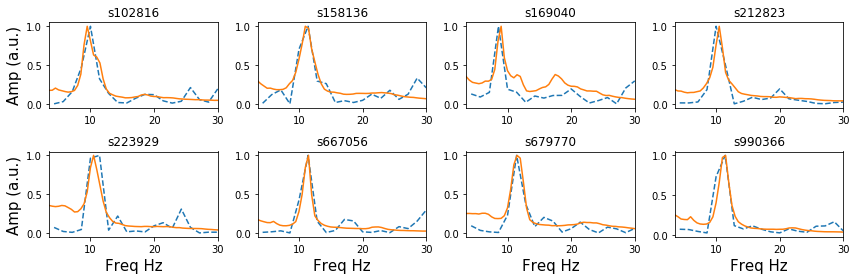

In [172]:
#Figure Xa: Model fits for four example subject from HCP

fig, ax = plt.subplots(nrows=2,ncols=4,figsize=(12,4))

#mysubs = [100307,106521,112920,105923]
mysubs = [102816, 158136, 169040, 212823, 223929, 667056, 679770, 990366]

flow,fhigh=0.,30.
for s_it,s in enumerate(mysubs):
    
    idx = bestfitcorrs[s]
    
    #kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    #a = ax[kv_it,0]
    a = ax.ravel()[s_it]
    
    df_all_fitdats.loc[s][idx].loc[flow:fhigh].plot(ax=a,linestyle='--',legend=False)#marker='.')
    meanps_norm[s].loc[flow:fhigh].plot(ax=a)    
    
    a.set_xlabel('Freq Hz', fontsize=15)
    a.set_ylabel('Amp (a.u.)',fontsize=15)
    #a.set_title('%s G-L Model fit to HCP MEG power spectrum' %s)
    a.set_title('s%s' %s)
    #plt.legend()
    
    
for a in ax[0][1:]: a.set_ylabel('')
for a in ax[1][1:]: a.set_ylabel('')
    
for a in ax[0]: a.set_xlabel('')
    
plt.tight_layout()
    

Mean subject fit

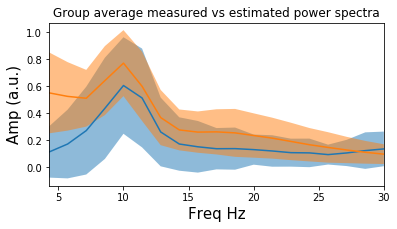

In [173]:
fig, ax = plt.subplots(figsize=(6,3))

flow,fhigh=0.,30.

bestfit_ps = pd.concat({k: df_all_fitdats.loc[k][v] for k,v in bestfitcorrs.items()}).unstack().T
bestfit_ps_megi2s = pd.concat({k: df_all_fitdats.loc[k]['meg_interp2sim'] for k,v in bestfitcorrs.items()}).unstack().T

mn = bestfit_ps.loc[:30].mean(axis=1)
std = bestfit_ps.loc[:30].std(axis=1)
mn.plot(ax=ax)
ax.fill_between(mn.index,mn-std,mn+std,alpha=0.5)

mn = bestfit_ps_megi2s.loc[:30].mean(axis=1)
std = bestfit_ps_megi2s.loc[:30].std(axis=1)
mn.plot(ax=ax)
ax.fill_between(mn.index,mn-std,mn+std,alpha=0.5)

    
ax.set_xlabel('Freq Hz', fontsize=15);
ax.set_ylabel('Amp (a.u.)',fontsize=15);
#a.set_title('%s G-L Model fit to HCP MEG power spectrum' %s)
ax.set_title('Group average measured vs estimated power spectra' );
#plt.legend()

Distribution of fits and parameters

In [161]:
Rs = pd.Series(bestfitcorrvals)
R2s = Rs**2

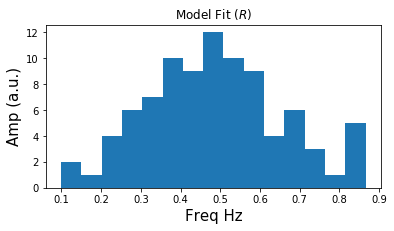

In [167]:
fig, ax = plt.subplots(figsize=(6,3))

Rs.plot(kind='hist',bins=15,ax=ax)

ax.set_xlabel('Freq Hz', fontsize=15);
ax.set_ylabel('Amp (a.u.)',fontsize=15);
#a.set_title('%s G-L Model fit to HCP MEG power spectrum' %s)
ax.set_title('Model Fit ($R$)');
#Group average measured and \nestimated power spectra' );
#plt.legend()


---

---

---

---

---

## Other stuff

Figure with log scaling

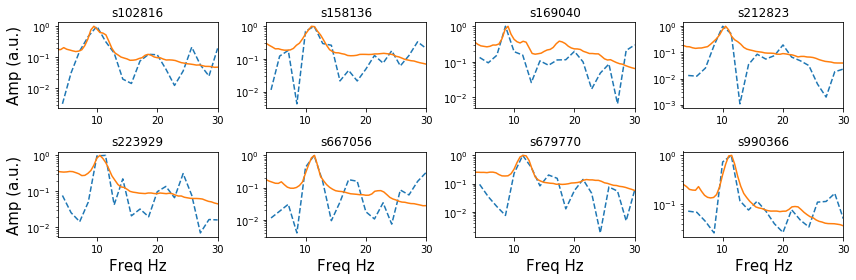

In [174]:
#Figure Xa: Model fits for four example subject from HCP

fig, ax = plt.subplots(nrows=2,ncols=4,figsize=(12,4))

#mysubs = [100307,106521,112920,105923]
mysubs = [102816, 158136, 169040, 212823, 223929, 667056, 679770, 990366]

flow,fhigh=0.,30.
for s_it,s in enumerate(mysubs):
    
    idx = bestfitcorrs[s]
    
    #kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    #a = ax[kv_it,0]
    a = ax.ravel()[s_it]
    
    df_all_fitdats.loc[s][idx].loc[flow:fhigh].plot(ax=a,linestyle='--',legend=False,logy=True)#marker='.')
    meanps_norm[s].loc[flow:fhigh].plot(ax=a,logy=True)    
    
    a.set_xlabel('Freq Hz', fontsize=15)
    a.set_ylabel('Amp (a.u.)',fontsize=15)
    #a.set_title('%s G-L Model fit to HCP MEG power spectrum' %s)
    a.set_title('s%s' %s)
    #plt.legend()
    
    
for a in ax[0][1:]: a.set_ylabel('')
for a in ax[1][1:]: a.set_ylabel('')
    
for a in ax[0]: a.set_xlabel('')
    
plt.tight_layout()
    

All subject fit plots

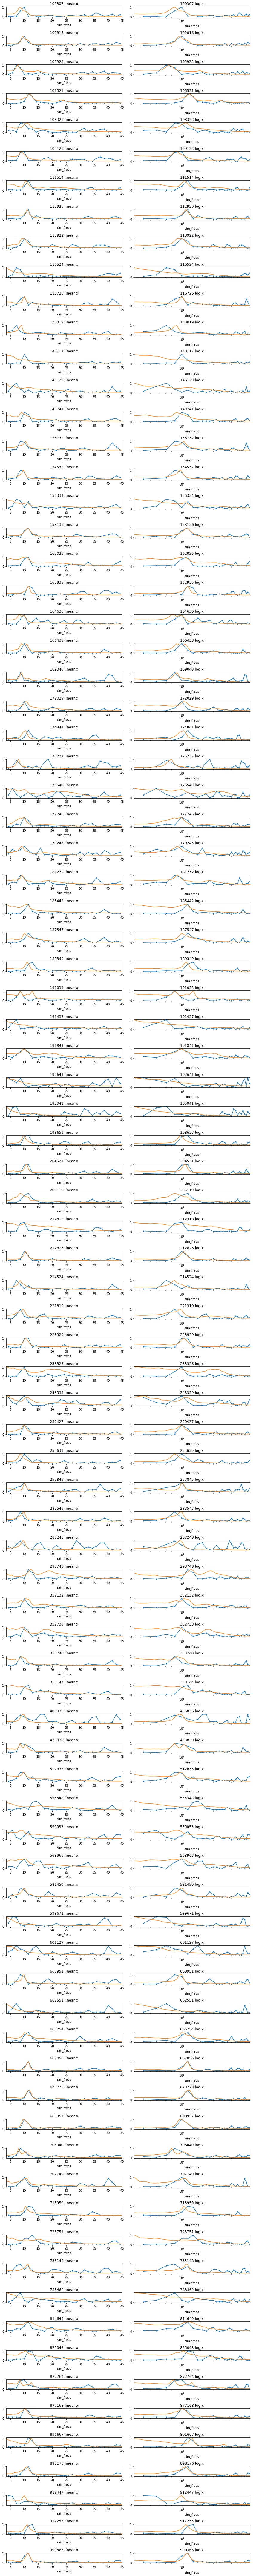

In [103]:
fig, ax = plt.subplots(nrows=len(bestfitcorrs),ncols=2,figsize=(12,120))

for kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    a = ax[kv_it,0]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.')
    meanps_norm[k].plot(ax=a)    
    a.set_title(str(k) + ' linear x')
    
    a = ax[kv_it,1]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.',logx=True,logy=False)#True)
    meanps_norm[k].plot(ax=a,logx=True,logy=False)#True)
    a.set_title(str(k) + ' log x')
   
plt.tight_layout()

Fit with all combs of a_rth and a_th

In [ ]:
%%time

#aths = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6]#,0.7,0.8,0.9,1.0]
#artns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6]#,0.7,0.8,0.9,1.0]
#combs = list(product(aths,artns))
#combsdicts = [{'a_th': i[0], 'a_rtn': i[1]} for i in combs]

a_thrtns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
combs = list(product(a_thrtns,a_thrtns))
combsdicts = [{'a_th': i[0], 'a_rtn': i[1]} for i in combs]


#%%time
#_a_eis = [0.7,0.8,0.9,1.0,1.1]
a_thrtns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
all_sims = {}
all_corrs = {}
all_sims_norm = {}
all_corrs_norm = {}
max_corrs = {}
max_corrs_norm = {}
noise_level = 0.01
T=1024*1

#### meg_dat = hcp_ps_norm.loc[3:45].mean(axis=1).values
#meg_freqs = hcp_ps_norm.loc[3:45].index.values


meanps = df_all_ps.mean(axis=1).unstack().T
substodo = meanps.columns


all_fitcorrs = {}
all_fitdats = {}


for sub in substodo:
    
    meg_dat = meanps.loc[2:46][sub].values
    meg_freqs = meanps.loc[2:46].index.values
    #meg_dat = hcp_ps_norm.loc[2:46].mean(axis=1).values
    #meg_freqs = hcp_ps_norm.loc[2:46].index.values

    for c_it,c in enumerate(combsdicts):
        ssX_params = dict(I_o=0., # None,
             wee = 1.4,wei = 1.4,wie = -3., wii = -0.5, # wie = -2.,wii = -0.5,
            wertn = 0.6,weth = .6,wthi = 0.2,wthe = 1.65,wrtnth = -2.,wthrtn = 2.,
            D_e=noise_level,D_i=noise_level,D_th=noise_level,D_rtn=noise_level,#D_e = .001,D_i= .001,D_th = 0.001,D_rtn = 0.001,
            T=T,#1024*1,#T,#T = 1024*4,# 20,
            P=1,Q = 1,Dt = 0.001,
            dt = 0.1,gain = 20.,threshold = 0.,Pi = 3.14159,
            g = 5., # 10., # 1., #-0.9,
            a_e = 0.9,
            a_i = 0.9, 
            a_th=0.25, 
            a_rtn=0.25, # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2,
            i_e = -0.35,i_i = -0.3,i_th = 0.5,i_rtn = -0.8,
            tau1  = 20.,tau2 = 5.,T_transient=1000,
            stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'],
            weights=weights_1N*0.,
            delays=delays_1N,
            K=1, #stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'], #weights=_df_w.values,delays=_df_d.values,K=83,
            return_ts=True,compute_connectivity=False,
            welch_nperseg=700)#True) #False)

        for k,v in c.items(): ssX_params[k] = v
        #sim_res = run_net_sim(**ssX_params)
        #sim_dat = sim_res[2]['e'].loc[3:45].mean(axis=1).values
        #sim_freqs = sim_res[2]['e'].loc[3:45].index.values
        #thing = interp1d(meg_freqs,meg_dat)
        #meg_interp2sim = thing(sim_freqs)#df.index)
        #all_sims[_a] = pd.DataFrame([meg_dat,meg_interp2sim,sim_dat,sim_freqs],index=['meg_dat', 'interp_sim_dat', 'freqs']).T
    
        sim_res = run_net_sim(**ssX_params)
        sim_dat = sim_res[1]['e'].loc[4:45].mean(axis=1).values
        sim_freqs = sim_res[1]['e'].loc[4:45].index.values
        thing = interp1d(meg_freqs,meg_dat)
        meg_interp2sim = thing(sim_freqs)#df.index)
        all_sims[c_it] = pd.DataFrame([meg_interp2sim,sim_dat,sim_freqs],index=['meg_interp2sim', 
                                                                      'sim_dat', 'sim_freqs']).T
        all_sims[c_it].set_index('sim_freqs', inplace=True)
    
    
        #sim_dat_norm = sim_dat/sim_dat.sum()
        #meg_interp2sim_norm = meg_interp2sim/meg_interp2sim.sum()
        sim_dat_norm = sim_dat/sim_dat.max()
        meg_interp2sim_norm = meg_interp2sim/meg_interp2sim.max()
    
        cc = np.corrcoef(sim_dat,meg_interp2sim)[0,1]
        all_corrs[c_it] = cc    
        df_all_corrs = pd.DataFrame(all_corrs.values(),index=all_corrs.keys())[0]
        max_corrs[c_it] = df_all_corrs.loc[df_all_corrs.idxmax()]
    
        cc_norm = np.corrcoef(sim_dat_norm,meg_interp2sim_norm)[0,1]
        all_corrs_norm[c_it] = cc_norm    
        df_all_corrs_norm = pd.DataFrame(all_corrs_norm.values(),index=all_corrs_norm.keys())[0]
        max_corrs_norm[c_it] = df_all_corrs_norm.loc[df_all_corrs_norm.idxmax()]    
 
    
    

    df_meg_interp2sim = pd.DataFrame(meg_interp2sim,index=sim_freqs)[0]
    #df_meg_interp2sim_norm = df_meg_interp2sim = df_meg_interp2sim.sum()
    df_meg_interp2sim_norm = df_meg_interp2sim = df_meg_interp2sim.max()

    df_all_sim_dats = pd.concat(all_sims)['sim_dat'].unstack().T
    df_all_sim_dats['meg_interp2sim'] = meg_interp2sim

    #df_all_sim_dats_norm = df_all_sim_dats / df_all_sim_dats.sum()
    df_all_sim_dats_norm = df_all_sim_dats / df_all_sim_dats.max()
    df_all_sim_dats_norm['meg_interp2sim'] = meg_interp2sim_norm 

    df_max_corrs = pd.DataFrame(max_corrs.values(),index=max_corrs.keys())[0]


    maxcorridx = df_all_sim_dats_norm.corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax()


    #fig, ax = plt.subplots(ncols=2, figsize=(12,3))

    #df_all_sim_dats_norm[[maxcorridx,'meg_interp2sim']].plot(logy=True,marker='.',ax=ax[0])
    #df_all_sim_dats_norm.corr().loc['meg_interp2sim'].drop('meg_interp2sim').plot(kind='bar',ax=ax[1])
    
    all_fitcorrs[sub] = df_max_corrs
    all_fitdats[sub] = df_all_sim_dats_norm

df_all_fitdats = pd.concat(all_fitdats)

bestfitcorrs = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax() for s in substodo}
bestfitcorrvals = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').max() for s in substodo}

meanps_norm = meanps/meanps.max()

fig, ax = plt.subplots(nrows=len(bestfitcorrs),ncols=2,figsize=(12,15))

for kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    a = ax[kv_it,0]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.')
    meanps_norm[k].plot(ax=a)    
    
    a = ax[kv_it,1]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.',logx=True,logy=False)#True)
    meanps_norm[k].plot(ax=a,logx=True,logy=False)#True)
   
plt.tight_layout()

CPU times: user 22min 33s, sys: 6.41 s, total: 22min 39s
Wall time: 8min 16s


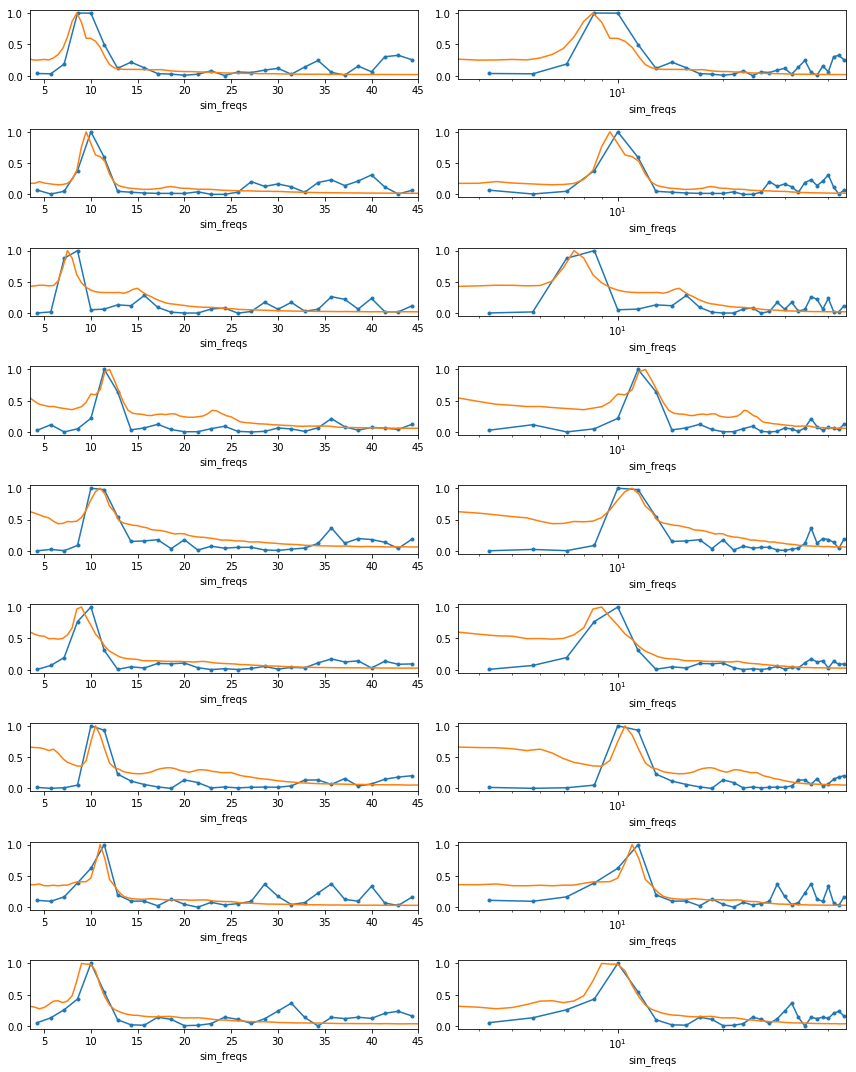

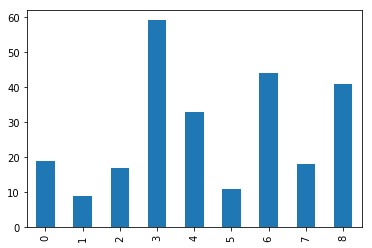

In [37]:
fig, ax  =plt.subplots()
pd.DataFrame(bestfitcorrs.values())[0].plot(kind='bar',ax=ax)

bestparam_vals = [combs[c] for c in bestfitcorrs.values()]
bestparam_vals